In [1]:
%pylab inline
import pandas
import os
import zipfile
import requests
import tqdm
from sklearn import dummy, metrics, cross_validation, ensemble

import keras.models as kmodels
import keras.layers as klayers
import keras.backend as K
import keras
import numpy as np

/usr/local/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
users = pandas.read_csv('./ml-1m/users.dat', sep='::', 
                        engine='python', 
                        names=['userid', 'gender', 'age', 'occupation', 'zip']).set_index('userid')
ratings = pandas.read_csv('./ml-1m/ratings.dat', engine='python', 
                          sep='::', names=['userid', 'movieid', 'rating', 'timestamp'])
movies = pandas.read_csv('./ml-1m/movies.dat', engine='python',
                         sep='::', names=['movieid', 'title', 'genre']).set_index('movieid')
movies['genre'] = movies.genre.str.split('|')

users.age = users.age.astype('category')
users.gender = users.gender.astype('category')
users.occupation = users.occupation.astype('category')
ratings.movieid = ratings.movieid.astype('category')
ratings.userid = ratings.userid.astype('category')

In [3]:
# Count the movies and users
n_movies = movies.shape[0]
n_users = users.shape[0]

# Also, make vectors of all the movie ids and user ids. These are
# pandas categorical data, so they range from 1 to n_movies and 1 to n_users, respectively.
movieid = ratings.movieid.cat.codes.values
userid = ratings.userid.cat.codes.values

In [4]:
# And finally, set up a y variable with the rating,
# as a one-hot encoded matrix.
#
# note the '- 1' for the rating. That's because ratings
# go from 1 to 5, while the matrix columns go from 0 to 4

y = np.zeros((ratings.shape[0], 5))
y[np.arange(ratings.shape[0]), ratings.rating - 1] = 1

## Build the model

In [5]:
# The embedding layer is normally used for sequences (think, sequences of words)
# so we need to flatten it out.
# The dropout layer is also important in preventing overfitting
movie_input = keras.layers.Input(shape=[1])
movie_vec = keras.layers.Flatten()(keras.layers.Embedding(n_movies + 1, 32)(movie_input))
movie_vec = keras.layers.Dropout(0.2)(movie_vec)

# Same thing for the users
user_input = keras.layers.Input(shape=[1])
user_vec = keras.layers.Flatten()(keras.layers.Embedding(n_users + 1, 32)(user_input))
user_vec = keras.layers.Dropout(0.2)(user_vec)

# Next, we join them all together and put them
# through a pretty standard deep learning architecture
input_vecs = keras.layers.merge([movie_vec, user_vec], mode='concat')
nn = keras.layers.Dropout(0.2)(keras.layers.Dense(512, activation='relu')(input_vecs))
nn = keras.layers.normalization.BatchNormalization( )(nn)
nn = keras.layers.Dropout(0.2)(keras.layers.Dense(512, activation='relu')(nn))
nn = keras.layers.normalization.BatchNormalization()(nn)
nn = keras.layers.Dense(128, activation='relu')(nn)

# Finally, we pull out the result!
result = keras.layers.Dense(5, activation='softmax')(nn)

# And make a model from it that we can actually run.
model = kmodels.Model([movie_input, user_input], result)
model.compile('Adagrad', 'categorical_crossentropy')

# If we wanted to inspect part of the model, for example, to look
# at the movie vectors, here's how to do it. You don't need to 
# compile these models unless you're going to train them.
#final_layer = kmodels.Model([movie_input, user_input], nn)
#movie_vec = kmodels.Model(movie_input, movie_vec)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: UserWarning: The `merge` function is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
/usr/local/lib/python2.7/dist-packages/keras/legacy/layers.py:460: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  name=name)


In [6]:
# Split the data into train and test sets...
a_movieid, b_movieid, a_userid, b_userid, a_y, b_y = cross_validation.train_test_split(movieid, userid, y, test_size = .2)

In [7]:
a_movieid.shape, b_movieid.shape, a_userid.shape, a_y.shape, b_y.shape
# And of _course_ we need to make sure we're improving, so we find the MAE before
# training at all.
#metrics.mean_absolute_error(np.argmax(b_y, 1)+1, np.argmax(model.predict([b_movieid, b_userid]), 1)+1)

((800167,), (200042,), (800167,), (800167, 5), (200042, 5))

## Train the model

In [8]:
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
MODEL_WEIGHTS_FILE = "REC_V2_1.h5"
try:
    
    callbacks = [EarlyStopping('val_loss', patience=2), 
             ModelCheckpoint(MODEL_WEIGHTS_FILE, save_best_only=True)]
    
    history = model.fit([a_movieid, a_userid], a_y, 
                         epochs=20, 
                         batch_size = 64,
                         validation_data=([b_movieid, b_userid], b_y), 
                         verbose=1, 
                         callbacks = callbacks)
except KeyboardInterrupt:
    pass

Train on 800167 samples, validate on 200042 samples
Epoch 1/20
800167/800167 [==============================] - 248s - loss: 1.3028 - val_loss: 1.2382
Epoch 2/20
800167/800167 [==============================] - 242s - loss: 1.2317 - val_loss: 1.2248
Epoch 3/20
800167/800167 [==============================] - 241s - loss: 1.2145 - val_loss: 1.2130
Epoch 4/20
800167/800167 [==============================] - 243s - loss: 1.2037 - val_loss: 1.2076
Epoch 5/20
800167/800167 [==============================] - 254s - loss: 1.1959 - val_loss: 1.2048
Epoch 6/20
800167/800167 [==============================] - 239s - loss: 1.1906 - val_loss: 1.2027
Epoch 7/20
800167/800167 [==============================] - 243s - loss: 1.1858 - val_loss: 1.2021
Epoch 8/20
800167/800167 [==============================] - 241s - loss: 1.1819 - val_loss: 1.1993
Epoch 9/20
800167/800167 [==============================] - 238s - loss: 1.1776 - val_loss: 1.1969
Epoch 10/20
800167/800167 [==============================

## Plot loss and validation loss

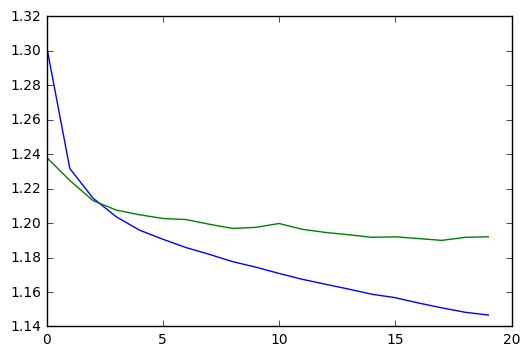

In [15]:
plot(history.history['loss'])
plot(history.history['val_loss'])

In [ ]:
metrics.mean_absolute_error(
    np.argmax(b_y, 1)+1, 
    np.argmax( model.predict([b_movieid, b_userid]), 1)+1)

In [10]:
ret = model.predict([b_movieid, b_userid])

In [12]:
movies.reset_index( inplace=True)

## Generate recommendations

In [13]:
USER = 6
ur = ratings[ ratings.userid ==  USER ].merge(movies, 
                                                on='movieid', 
                                                how='inner', 
                                                suffixes=['_u', '_m'])
                                                
ur.sort_values(by='rating', ascending=False).head(20)                                                    

,userid,movieid,rating,timestamp,title,genre
0,6,2406,5,978236670,Romancing the Stone (1984),"[Action, Adventure, Comedy, Romance]"
12,6,48,5,978237570,Pocahontas (1995),"[Animation, Children's, Musical, Romance]"
36,6,3536,5,978238230,Keeping the Faith (2000),"[Comedy, Romance]"
38,6,3753,5,978238195,"Patriot, The (2000)","[Action, Drama, War]"
46,6,1947,5,978237767,West Side Story (1961),"[Musical, Romance]"
47,6,2966,5,978237273,"Straight Story, The (1999)",[Drama]
23,6,597,5,978239019,Pretty Woman (1990),"[Comedy, Romance]"
52,6,1088,5,978236670,Dirty Dancing (1987),"[Musical, Romance]"
54,6,199,5,978237570,"Umbrellas of Cherbourg, The (Parapluies de Che...","[Drama, Musical]"
33,6,3604,5,978237767,Gypsy (1962),[Musical]


In [14]:
nr = np.asarray(ratings[ ~ratings.movieid.isin( ur.movieid)]['movieid'].unique()).astype(np.int16)
test_user = np.ones( nr.shape, dtype=np.int)*USER
ret = model.predict( [nr, test_user])
#best = np.argmax( ret, axis = 1)
#best = np.where( best >= 4)[0]
best = np.where( ret>.82)[0]
movies[ movies.movieid.isin( nr[best] )].head(n=20)

,movieid,title,genre
48,49,When Night Is Falling (1995),"[Drama, Romance]"
104,106,Nobody Loves Me (Keiner liebt mich) (1994),"[Comedy, Drama]"
250,253,Interview with the Vampire (1994),"[Drama, Horror]"
284,287,Nina Takes a Lover (1994),"[Comedy, Romance]"
306,309,"Red Firecracker, Green Firecracker (1994)",[Drama]
386,390,Faster Pussycat! Kill! Kill! (1965),"[Action, Comedy, Drama]"
509,513,Radioland Murders (1994),"[Comedy, Mystery, Romance]"
575,579,"Scorta, La (1993)",[Thriller]
641,647,Courage Under Fire (1996),"[Drama, War]"
699,708,"Truth About Cats & Dogs, The (1996)","[Comedy, Romance]"
